In [3]:
'''
The script reads sst raw data from CESM-LENS and output:
1) pre-process and concatenate 40 ensembles of sst in north Atlantic and tropical Pacific
2) conduct EOF analysis of sst

'''

In [ ]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd
from eofs.xarray import Eof

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy as cart
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

import pickle
import joblib

In [4]:
# return monthly average and regional longitude, latitude
# extract and group each month data
# after calculate the anomaly, remove the outliers
def month_data_sst(anom, month):
    month_group = anom.groupby("time.month").groups # group into seasons, use groups to read each group
    month_index = month_group[month]
    month_anom = anom[month_index,:,:,:]

    return month_anom


# calculate normalized anomalies of sst
# climatology based on 1976 to 2005 
def nor_anom(dataset):
    ds_clm = dataset.sel(time=slice("1976", "2005")).load()

    rr_clm = ds_clm

    gb_clm = rr_clm.groupby("time.month") # gb_clm: grouped data into 12 month for climatology
    gb = dataset.groupby("time.month")
    prcp_anom = ((gb - gb_clm.mean(dim="time")).groupby("time.month"))/gb_clm.std(dim="time") # normalized

    return prcp_anom

In [5]:
def data_load_cesm_sst(fn, start, end, region): # 'TP' 'NA' 'MD'
    ds_xr = xr.open_dataset(fn, chunks={"time": 10})
    ds_xr = ds_xr.sel(time=slice(start, end)).load()
    
    # How to extract the desired region? -- by calculation
    reg_lon_xr = ds_xr['nlon'] # from -40.375W to 75.375E
    reg_lat_xr = ds_xr['nlat'] # from 25.375N to 75.375N
    temp_xr = ds_xr['SST']
    if region == 'TP': 
        # combine for merge two dataset with same coordinate
        xr1 = temp_xr[:,:,114:255,130:295]
    if region == 'NA': 
        # combine for merge two dataset with same coordinate
        xr1 = xr.concat([temp_xr[:,:,187:369,284:], temp_xr[:,:,187:369,:41]], dim="nlon")
        #xr1 = temp_xr[:,:,187:341,4:41]
    if region == 'MD': 
        # combine for merge two dataset with same coordinate
        xr1 = temp_xr[:,:,275:314,30:75]
   
    # time, lat, lon
    return xr1, reg_lat_xr, reg_lon_xr

In [6]:
import os
path = r'C:/Users/yzh086/OneDrive - University of Bergen/PhD_lit/PhD_lit/task1/Data/CESM1/sst'
filelist = os.listdir(path)

pathlist = []
for i in range(len(filelist)):
    temp = path + '/' + filelist[i]
    pathlist.append(temp)
    
fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

In [64]:
# start with SST in TP -40-20, 130-290
fn1 = pathlist[0]
ds_xr = xr.open_dataset(fn1, chunks={"time": 10})

In [5]:
# preprocess SST -- all data together
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## change parameter for different region ##
region = 'NA'

fn1 = pathlist[0]
# take the right time
temp_xr = xr.open_dataset(fn1, chunks={"time": 10})
### only ensemble 1 have 192001 ###
temp_xr = temp_xr.sel(time=slice('192001', '200512')).load() # be aware of the time here!!!

sst_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_sst(fn1, '192002', '200601', region)

# calculate anomaly
sst_anom = nor_anom(sst_xr)

# detrend the time series at each grid point
sst_danom = detrend_dim(sst_anom, 'time', deg=1)

# extract and group each season data
anom_original = sst_danom

data = np.squeeze(sst_danom.values) # remove dimension = 1
time = temp_xr.time
tlat = sst_danom.TLAT
tlong = sst_danom.TLONG
anom_ensemble = xr.DataArray(data, 
                    coords={'time':time, 
                            'TLAT':(("nlat", "nlon"), np.array(tlat)),
                            'TLONG':(("nlat", "nlon"), np.array(tlong))},  # format for multiple dimensions
                    dims=['time', 'nlat', 'nlon'])

In [6]:
##### process to ensemble #####
for i in range(1,len(filelist)):

    fn1 = pathlist[i]
    sst_xr, reg_lat_xr, reg_lon_xr = data_load_cesm_sst(fn1, '192002', '200601', region)

    # calculate anomaly
    sst_anom = nor_anom(sst_xr)

    # detrend the time series at each grid point
    sst_danom = detrend_dim(sst_anom, 'time', deg=1)
    
    data = np.squeeze(sst_danom.values) # remove dimension = 1
    time = temp_xr.time
    tlat = sst_danom.TLAT
    tlong = sst_danom.TLONG
    anom_gb_temp = xr.DataArray(data, 
                        coords={'time':time, 
                                      'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                        dims=['time', 'nlat', 'nlon'])


    anom_ensemble = xr.concat([anom_ensemble,anom_gb_temp], dim='time')

In [7]:
### save and load as netcdf ###
anom_ensemble.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_na.nc')

In [86]:
region= 'tp'

In [87]:
### save and load as netcdf ###
ensemble = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\ensemble_data\sst\sst_tp.nc'
                           )

In [89]:
ensemble = ensemble.__xarray_dataarray_variable__

In [91]:
##### preprocessing wrong data ####
ensemble[33243] = ensemble[33231]

In [93]:
### ways to calculate seasonal pc ###

### For winter ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([12,1,2])] # select data of 12,1,2 month
# take the rolling series from 1921 to 2005
sst_rolling = sst_all[2:-1]
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 2]
# mean at 1920
sst1 = sst_all[:2].mean(dim='time')
# reshape time to (1,)
time = sst_all[1].time.values.reshape(1,)
#lat = sst_all[1].lat
#lon = sst_all[1].lon
tlat = sst_all[1].TLAT
tlong = sst_all[1].TLONG
#sst1 = xr.DataArray(sst1.values.reshape(1,64,105),coords=[time,lat,lon],dims=('time', 'lat', 'lon'))
sst1 = xr.DataArray(sst1.values.reshape(1,sst_all.shape[1],sst_all.shape[2]),coords={'time':time, 
                                      'TLAT':(("nlat", "nlon"), np.array(tlat)),
                                      'TLONG':(("nlat", "nlon"), np.array(tlong))}, 
                                        dims=['time', 'nlat', 'nlon'])

# concat two array
sst_series = xr.concat([sst1, sst2], dim="time")

In [94]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = np.mean(sst_series.TLAT[:,0], axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(141, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

In [95]:
eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_eof_djf_%s.nc' % region)
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_pc_djf_%s.nc' % region)
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_var_djf_%s.nc' % region)
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_lam_djf_%s.nc' % region)

In [97]:
### ways to calculate seasonal pc ###

### For MAM ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([3,4,5])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 5]

# concat two array
sst_series = sst2

In [99]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = np.mean(sst_series.TLAT[0], axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(141, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_eof_mam_%s.nc' % region)
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_pc_mam_%s.nc' % region)
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_var_mam_%s.nc' % region)
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_lam_mam_%s.nc' % region)

In [100]:
### ways to calculate seasonal pc ###

### For JJA ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([6,7,8])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 8]

# concat two array
sst_series = sst2

In [101]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = np.mean(sst_series.TLAT[0], axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(141, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_eof_jja_%s.nc' % region)
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_pc_jja_%s.nc' % region)
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_var_jja_%s.nc' % region)
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_lam_jja_%s.nc' % region)

In [102]:
### ways to calculate seasonal pc ###

### For JJA ###
sst_raw = ensemble
# find SEASONAL data
sst_all = sst_raw[sst_raw.time.dt.month.isin([9,10,11])] # select data of each season
# take the rolling series from 1921 to 2005
sst_rolling = sst_all
sst_mean1 = sst_rolling.rolling(time = 3).mean()
# mean value at each step 3
sst2 = sst_mean1[sst_mean1.time.dt.month == 11]

# concat two array
sst_series = sst2

In [103]:
### EOF ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = np.mean(sst_series.TLAT[0], axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
#wgts   = np.array(wgts).reshape(len(wgts), 1)
wgts   = np.array(wgts).reshape(141, 1) ## depends on the shape of region

solver = Eof(sst_series, weights=wgts)

eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_eof_son_%s.nc' % region)
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_pc_son_%s.nc' % region)
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_var_son_%s.nc' % region)
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\eof_sst\TP\sst_lam_son_%s.nc' % region)

In [15]:
### calculate monthly EOF(pc) ###
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from scipy import stats

# weighted by latitude
meantlat = np.mean(ensemble.TLAT[0], axis = 1)
wgts   = np.cos(np.deg2rad(meantlat))
wgts   = np.array(wgts).reshape(182, 1) ## depends on the shape of region

solver = Eof(ensemble, weights=wgts)

In [16]:
eof_en = solver.eofs(neofs=10)
pc_en  = solver.pcs(npcs=10, pcscaling=0)
varfrac_en = solver.varianceFraction()
lambdas_en = solver.eigenvalues()

eof_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_eof_na.nc')
pc_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_pc_na.nc')
varfrac_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_var_na.nc')
lambdas_en.to_netcdf(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_lam_na.nc')

In [23]:
### save and load as netcdf ###
eof_en_ = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_eof1.nc')
pc_en_ = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_pc1.nc')
varfrac_en_ = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_var1.nc')
lambdas_en_ = xr.open_dataset(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\processed_data\sst_lam1.nc')

In [129]:
### re-apply for new coordinate since it is not equally placed ###
### this should be changed by different region ###
new_long = np.linspace(-80,6,77) # 110 E to 75 W
new_lat = np.linspace(0,70,182) # -20 to 20

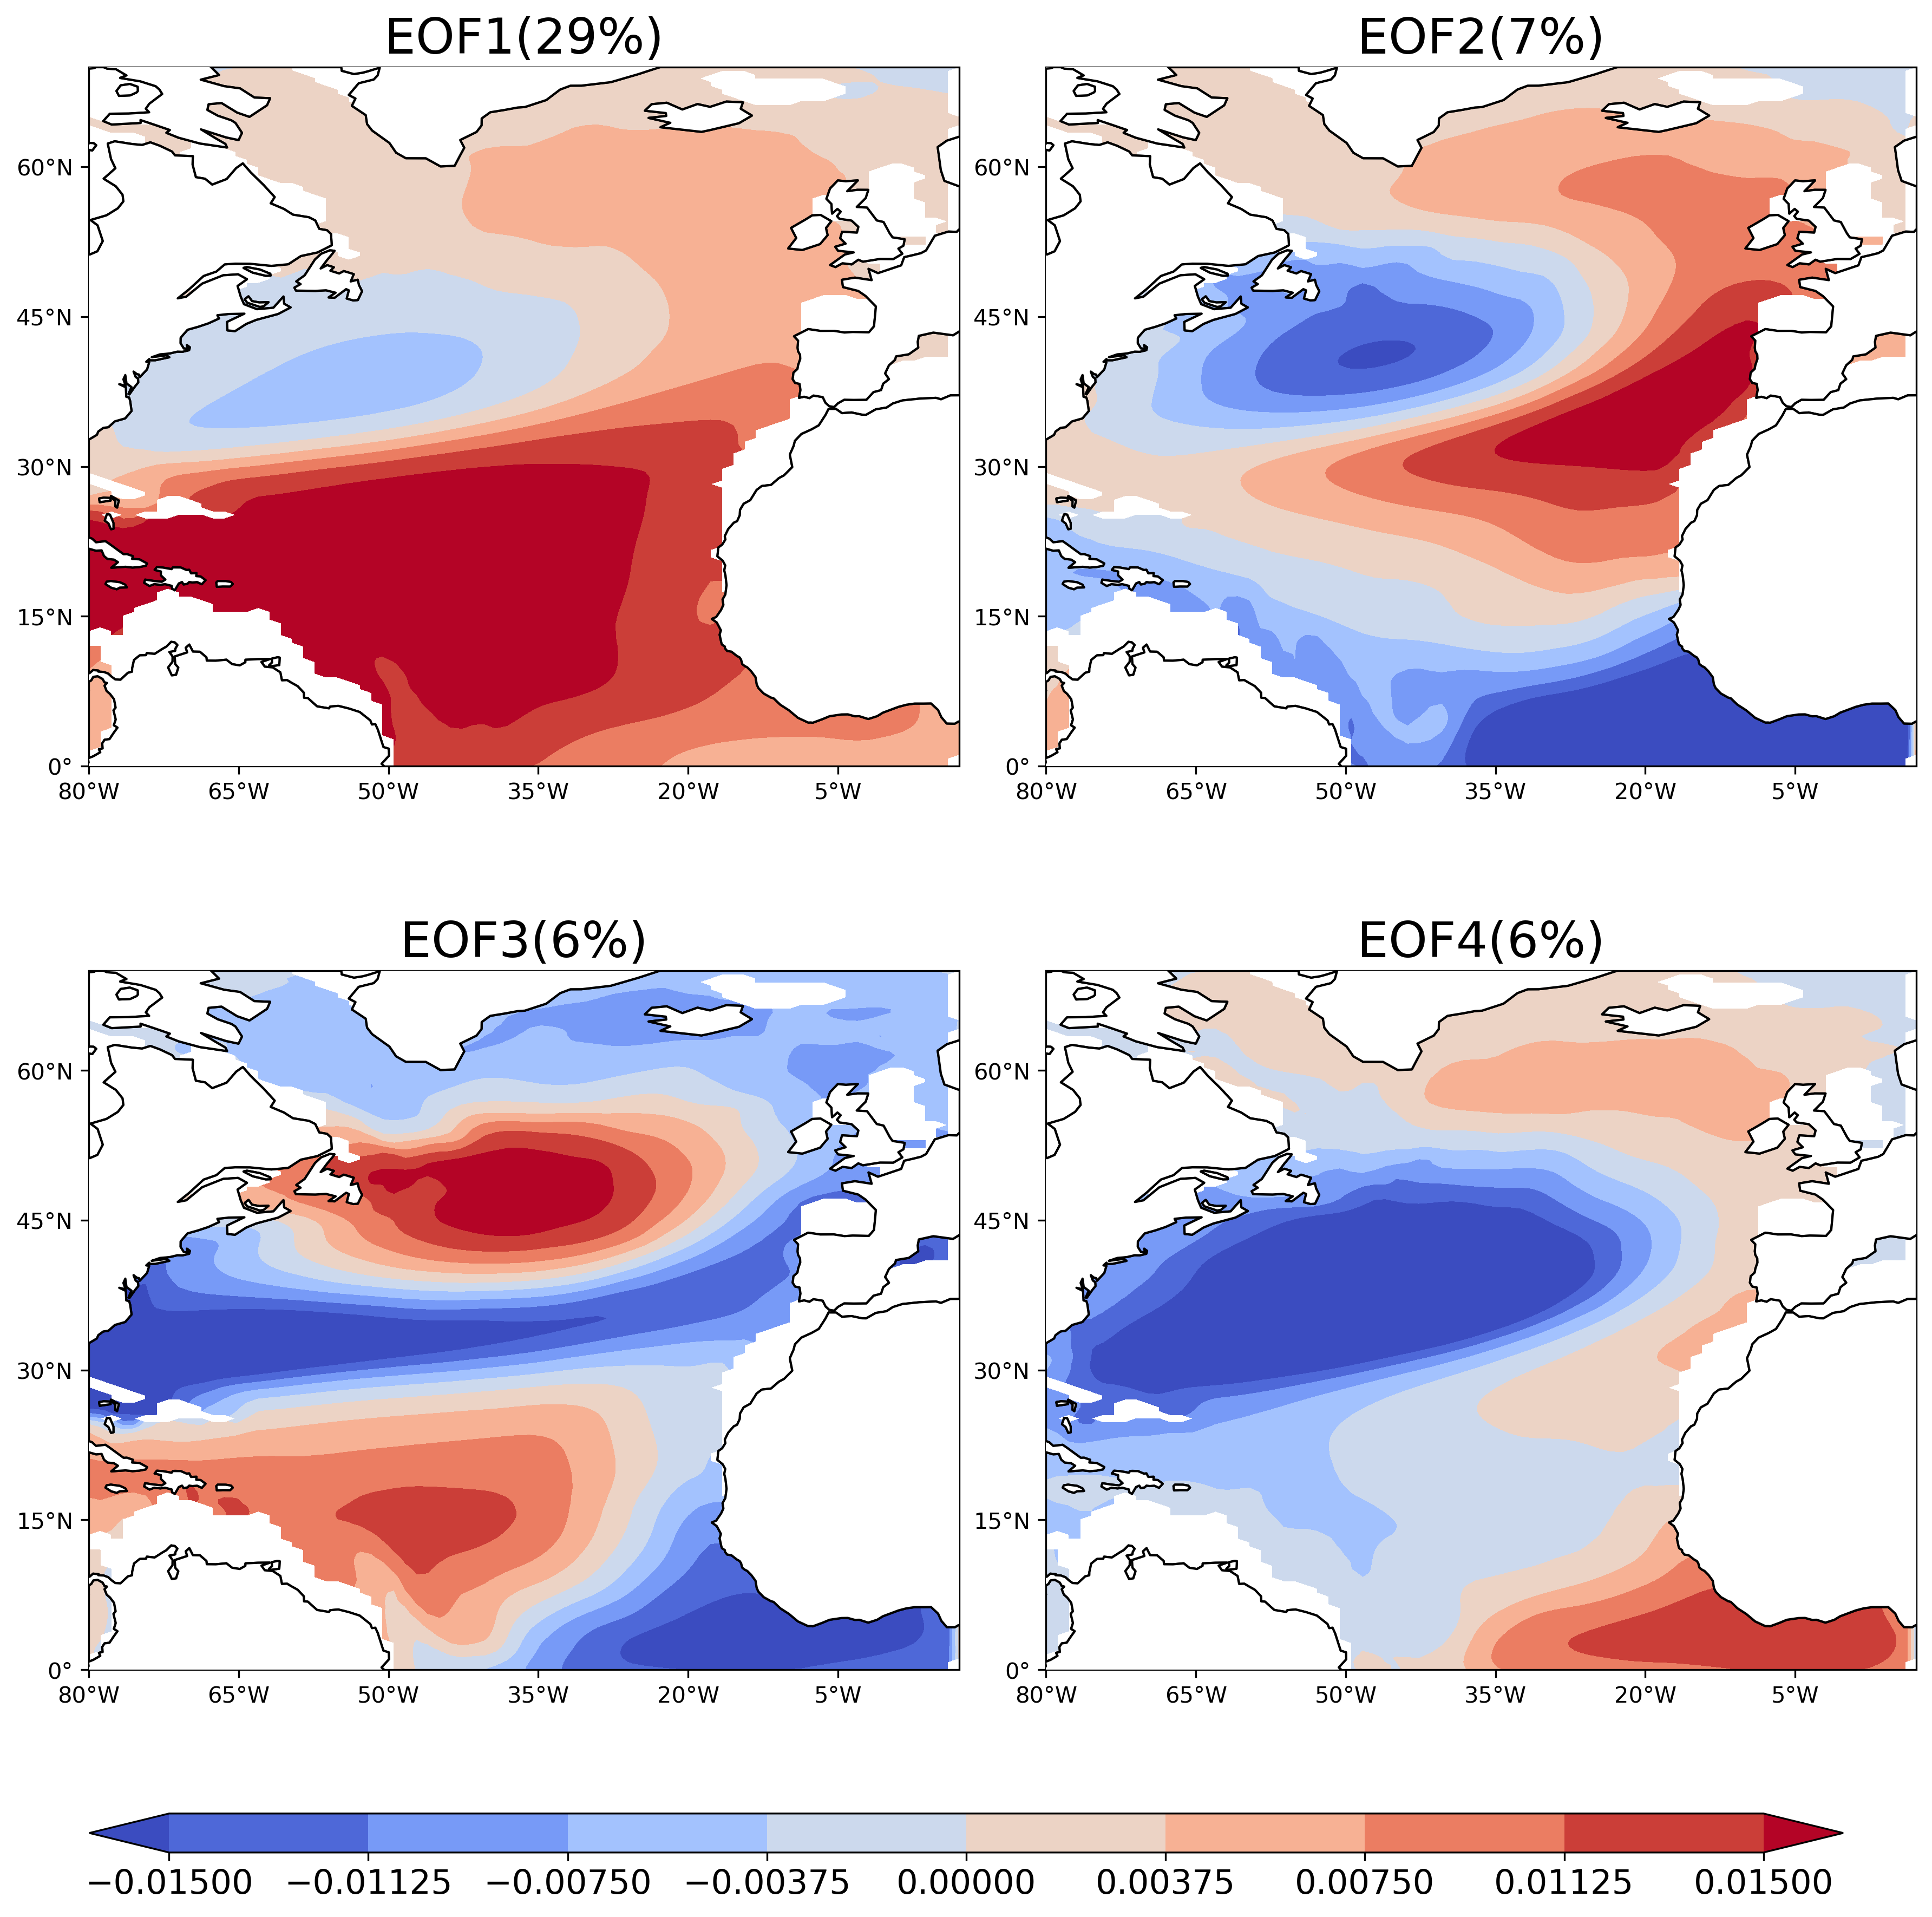

In [136]:
##### finally plot #####

fig, axs = plt.subplots(2,2, figsize=(12,12), subplot_kw=dict(projection=ccrs.PlateCarree()),dpi =300)

fig = plt.gcf()

for ax, i in zip(axs.ravel(), range(4)):

    title2 = 'EOF%s(%s%%)' % (i+1, int(varfrac_en[i]*100))
    # tim
    data = eof_en[i]
    # Add cyclic point to data
    data, lons = add_cyclic_point(data, coord=new_long)
    lat = new_lat
    # Make a filled contour plot
    # Add coastlines
    ax.coastlines()

    # mask the LAND part with white color
    ax.add_feature(cart.feature.LAND, facecolor = 'white', zorder=200, edgecolor='k')

    cs=ax.contourf(lons, new_lat, data,
                transform = ccrs.PlateCarree(),cmap='coolwarm',levels = np.linspace(-0.015,0.015,9),
                   extend='both') # (lat, lon)

    # Define the xticks for longitude

    ax.set_xticks(np.arange(-80,6,15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)

    # Define the yticks for latitude
    ax.set_title(title2, fontsize = 22)

    ax.set_yticks(np.arange(0,70,15), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)

fig.tight_layout() 
fig.subplots_adjust(bottom = 0.1, top = 0.95, hspace =0.2, wspace=.1)    

# Add colorbar
bar_cax = plt.axes([0.05, 0.02, 0.9,0.02]) # left&right, bottom, size, size
cbar = plt.colorbar(cs,cax = bar_cax, orientation = 'horizontal', fraction = 0.05)
cbar.ax.tick_params(labelsize = 15)
  
    
fig.savefig(r'C:\Users\yzh086\OneDrive - University of Bergen\PhD_lit\PhD_lit\task1\result\eof\sst\%s\eof_test.png' % region)

(-246.9825859283952, 216.65279469497403)

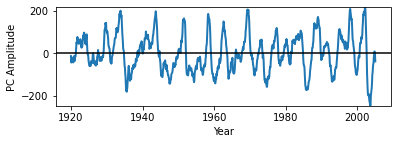

In [148]:
plt.subplot(212)
days = np.linspace(1920,2005,1032)
plt.plot(days, pc[:,0], linewidth=2)
plt.axhline(0, color='k')
plt.xlabel('Year')
plt.ylabel('PC Amplitude')   
plt.ylim(np.min(pc[:,0].squeeze()), np.max(pc[:,0].squeeze()))

(2.4410168164804293e-35, 0.3589619955853312)

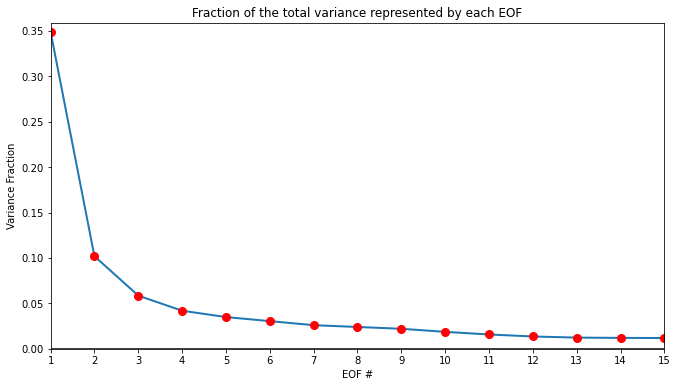

In [37]:
#Check variances explained by leading EOFs

plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac_en[0:15], linewidth=2)
plt.plot(eof_num, varfrac_en[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac_en), np.max(varfrac_en)+0.01)